In [2]:
import cv2
import os
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Path to the dataset

In [3]:
dataset_path = '/kaggle/input/att-database-of-faces'

# Read images

X shape: (400, 10304)
y shape: (400,)


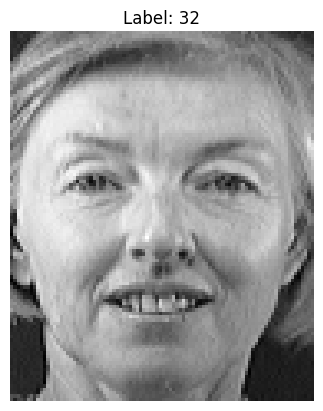

In [4]:
images = []
labels = []

for person_dir in os.listdir(dataset_path):
    person_path = os.path.join(dataset_path, person_dir)
    if os.path.isdir(person_path):
        label = int(person_dir[1:])
        for image_name in os.listdir(person_path):
            image_path = os.path.join(person_path, image_name)
            # Grayscale images of shape (112, 92)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            # Flatten the image to be has shape (112 * 92 -> 10304, )
            img_flattened = img.flatten()
            images.append(img_flattened)
            labels.append(label)

# Convert lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Get the shape of the dataset and its label
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Show one image
plt.imshow(X[0].reshape(112, 92), cmap='gray')
plt.title(f"Label: {y[0]}")
plt.axis('off')
plt.show()

# Split data into training and testing data 

In [5]:
X_train = []
y_train = []
X_test = []
y_test = []

m,_ = X.shape
for i in range(0, m-1, 2):
    X_train.append(X[i])
    y_train.append(y[i])
    X_test.append(X[i+1])
    y_test.append(y[i+1])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Get the shape of the splited dataset and its label
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (200, 10304)
y_train shape: (200,)
X_test shape: (200, 10304)
y_test shape: (200,)


# PCA

In [17]:
class PCA:
    def __init__(self, n_components=None, alpha=None):
        """
        Parameters:
        - n_components: int, number of components to keep
        - alpha: float (0-1), minimum variance ratio to retain
        """
        self.n_components = n_components
        self.alpha = alpha
        self.components = None
        self.mean = None
        self.explained_variance_ratio = None
    
    def fit(self, X):
        # 1. Standardize the data (center to mean)
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Save/load eigenvalues and eigenvectors
        if os.path.exists('eigenvalues.npy') and os.path.exists('eigenvectors.npy'):
            self.eigenvalues = np.load('eigenvalues.npy')
            self.eigenvectors = np.load('eigenvectors.npy')
        else:
            cov_matrix = np.cov(X_centered, rowvar=False)
            eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
            sorted_indices = np.argsort(eigenvalues)[::-1]
            self.eigenvalues = eigenvalues[sorted_indices]
            self.eigenvectors = eigenvectors[:, sorted_indices]
            
            np.save('eigenvalues.npy', self.eigenvalues)
            np.save('eigenvectors.npy', self.eigenvectors)
        
        # 5. Compute explained variance ratio ??
        total_variance = np.sum(self.eigenvalues)
        self.explained_variance_ratio = self.eigenvalues / total_variance
        
        # 6. Determine number of components to keep 
        if self.alpha is not None:
            cumulative_variance = np.cumsum(self.explained_variance_ratio)
            self.n_components = np.argmax(cumulative_variance >= self.alpha) + 1
        
        # 7. Select top components with max eigenvalue
        self.components = self.eigenvectors[:, :self.n_components] ## using in inverse transform
        
        return self
    
    def transform(self, X):
        # Center the data using the mean from training
        X_centered = X - self.mean
        
        # Project data onto principal components
        return np.dot(X_centered, self.components)
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

# Autoencoder

In [18]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim=10304, latent_dim=100):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.Sigmoid()  # Assuming images are normalized
        )
    
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
        return reconstructed, latent

# K-means

In [19]:
class KMeans:
    def __init__(self, n_clusters=3, max_iters=1000, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol

    def fit(self, X, y=None):
        self.y_true = y  # Store true labels if provided
        
        # Initialize centroids randomly from the dataset
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]
        for i in range(self.max_iters):
            # Assign each point to the nearest centroid
            self.labels = self._assign_cluster_labels(X, y)
            
            # Calculate new centroids
            new_centroids = self._calculate_centroids(X)
            
            # Check for convergence (if the centroids don't change much)
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
                
            self.centroids = new_centroids

    def _assign_labels(self, X):
        # Compute distance from each point to each centroid
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        # Assign labels based on closest centroid
        return np.argmin(distances, axis=1)

    def _assign_cluster_labels(self, X, y=None):
        # Compute distances and find the nearest cluster
        distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
        cluster_indices = np.argmin(distances, axis=1)

        if y is None:
            return cluster_indices
        else:
            # Assign majority label within each cluster
            labels = np.zeros_like(cluster_indices)
            for cluster in range(self.n_clusters):
                indices = np.where(cluster_indices == cluster)[0]
                if len(indices) > 0:
                    majority_label = Counter(y[indices]).most_common(1)[0][0]
                    labels[indices] = majority_label
            return labels

    def _calculate_centroids(self, X):
        # Calculate the mean of the points assigned to each centroid
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
            points = X[self.labels == i]
            if len(points) > 0:
                centroids[i] = points.mean(axis=0)
        return centroids

    def predict(self, X):
        return self._assign_cluster_labels(X)

# Training using PCA

In [20]:
# First, train PCA for each alpha for the training and test data
alphas = [0.8, 0.85, 0.9, 0.95]

# Standardize the data (important for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Dictionary to store PCA-transformed datasets {alpha: pca data}
pca_transformed_trained_data = {}
pca_transformed_tested_data = {}

for alpha in alphas:
    pca = PCA(alpha=alpha)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    pca_transformed_trained_data[alpha] = X_train_pca
    pca_transformed_tested_data[alpha] = X_test_pca
    print(f"PCA at alpha={alpha}")
    print(f"Shape of the PCA trained data ={X_train_pca.shape}")
    print(f"Shape of the PCA tested data ={X_test_pca.shape}")
    print("="*100)

PCA at alpha=0.8
Shape of the PCA trained data =(200, 37)
Shape of the PCA tested data =(200, 37)
PCA at alpha=0.85
Shape of the PCA trained data =(200, 52)
Shape of the PCA tested data =(200, 52)
PCA at alpha=0.9
Shape of the PCA trained data =(200, 76)
Shape of the PCA tested data =(200, 76)
PCA at alpha=0.95
Shape of the PCA trained data =(200, 115)
Shape of the PCA tested data =(200, 115)


In [21]:
# Then, for each transformed dataset, train KMeans
clusters = [20, 40, 60]

# Structure: {alpha: {k: model}}
kmeans_models = defaultdict(dict)

for alpha, X_train_pca in pca_transformed_trained_data.items():
    for k in clusters:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_train_pca, y_train)
        kmeans_models[alpha][k] = kmeans

model = kmeans_models[0.8][40]
print(f"At alpha=0.8 and k=40 cluster labels:\n{model.labels}")

At alpha=0.8 and k=40 cluster labels:
[32 32 15 32 32 39 39 39 39 39 26 26 26 26 26 20  3 20 20 20 18 18 18 18
 18  4 25 25  4 25 24 24 24 24 24 14 14 14 14 14 18 18 25 18 25 19 17 17
 19 19 33 21 21 33 33  2  1  1  1  1 11 11 11 11 11 34 30 30 34 34 15  1
  4 25 25 18 18 18 25 18 19 15 19 19 19 33 33 30 33 30 37 37 14 14 14 10
 38 10 10 10  8  8  8  8  8 25 18 18 25 25  7  7  7  7  7 28 15 28 15 14
  9  9  9  9  9 15 15 15 15 15 21 21 21 21 21  2  2  2  2  2  6  6  6  6
  6 30 30 30 30 30  3  3  4  3  4 30 38 38  3 38  4  4  4  4  4 24  2 15
 24  1 38 38 38 38  4 17 36 36 17 17 36 36 36 36 36 39 39 39 39 39 34 34
 34 34 34 26 26 26 26 26]


# Testing using PCA

In [22]:
predictions = defaultdict(dict)

for alpha, models_by_k in kmeans_models.items():
    # Get the PCA-transformed test data
    X_test_pca = pca_transformed_tested_data[alpha]  

    for k, model in models_by_k.items():
        y_pred = model.predict(X_test_pca)
        predictions[alpha][k] = y_pred

# Evaluation using PCA

Alpha: 0.8, k: 20:
Accuracy: 0.03
F1-Score: 0.01


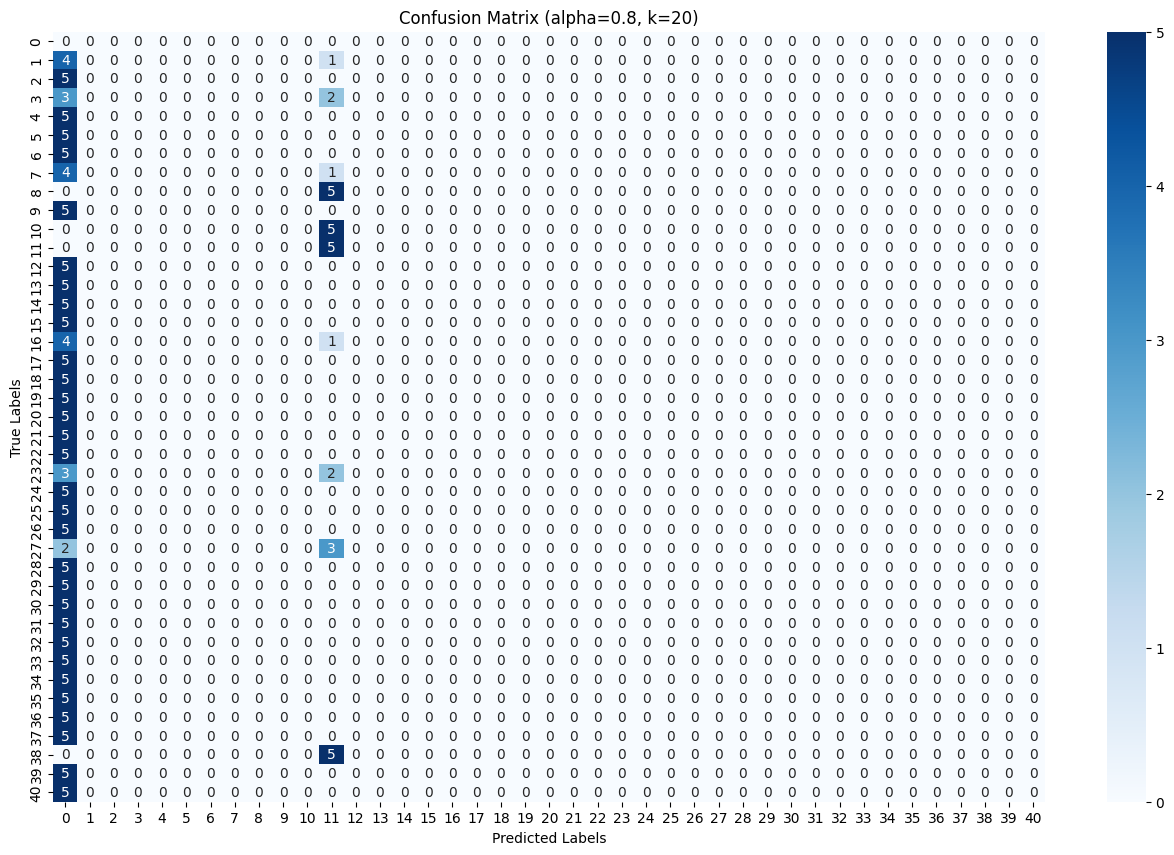

Alpha: 0.8, k: 40:
Accuracy: 0.56
F1-Score: 0.48


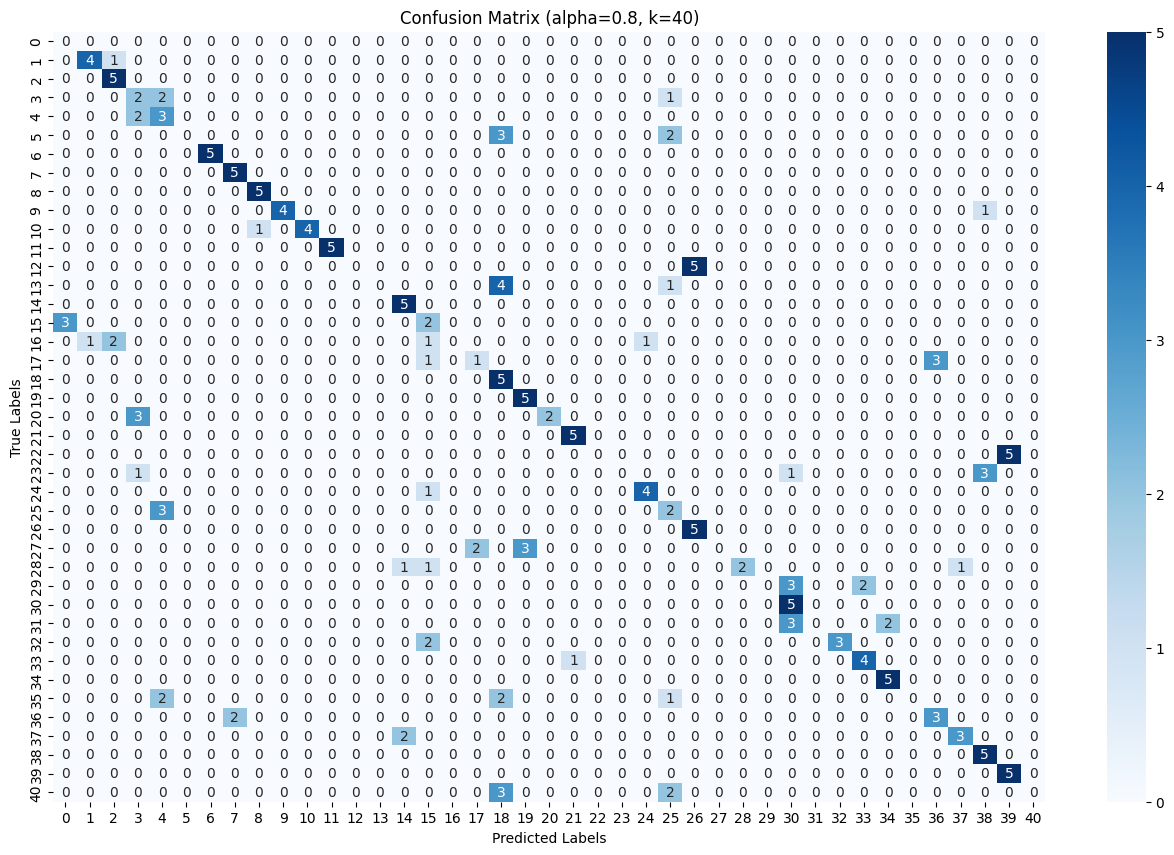

Alpha: 0.8, k: 60:
Accuracy: 0.69
F1-Score: 0.64


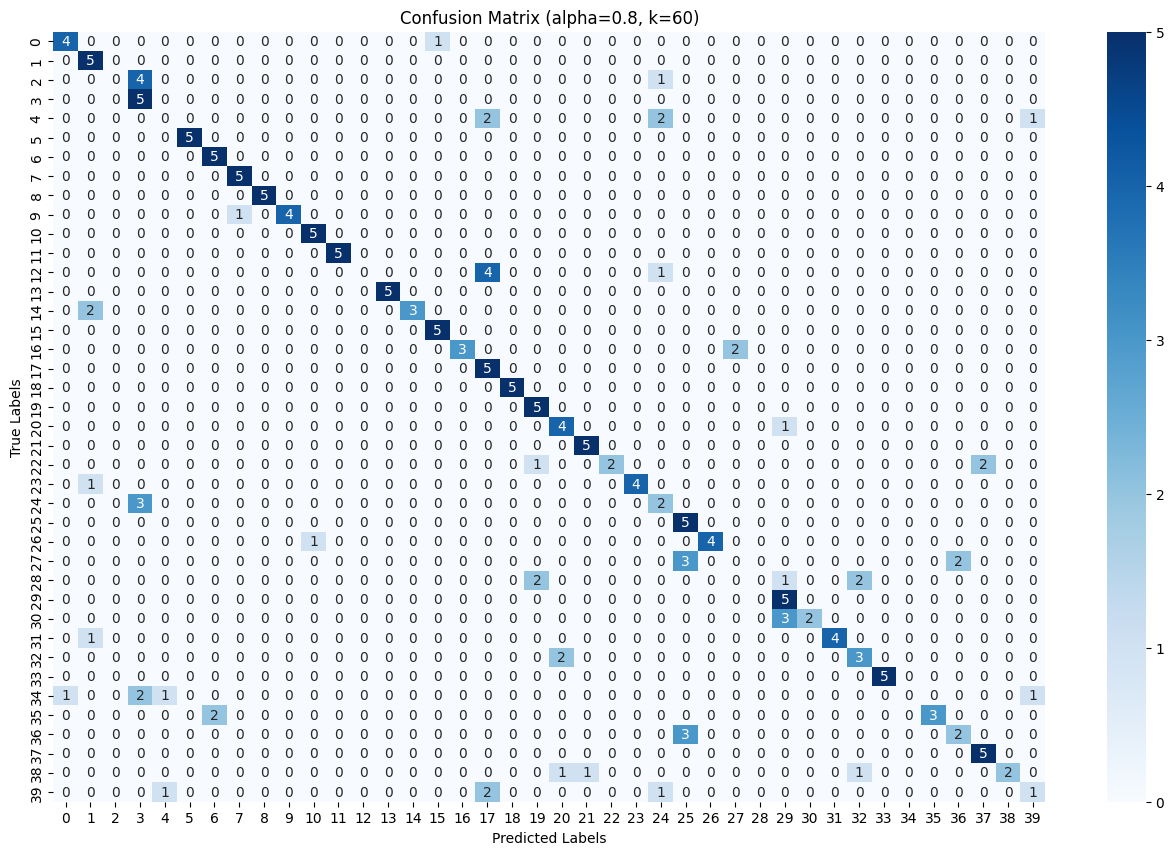

Alpha: 0.85, k: 20:
Accuracy: 0.05
F1-Score: 0.03


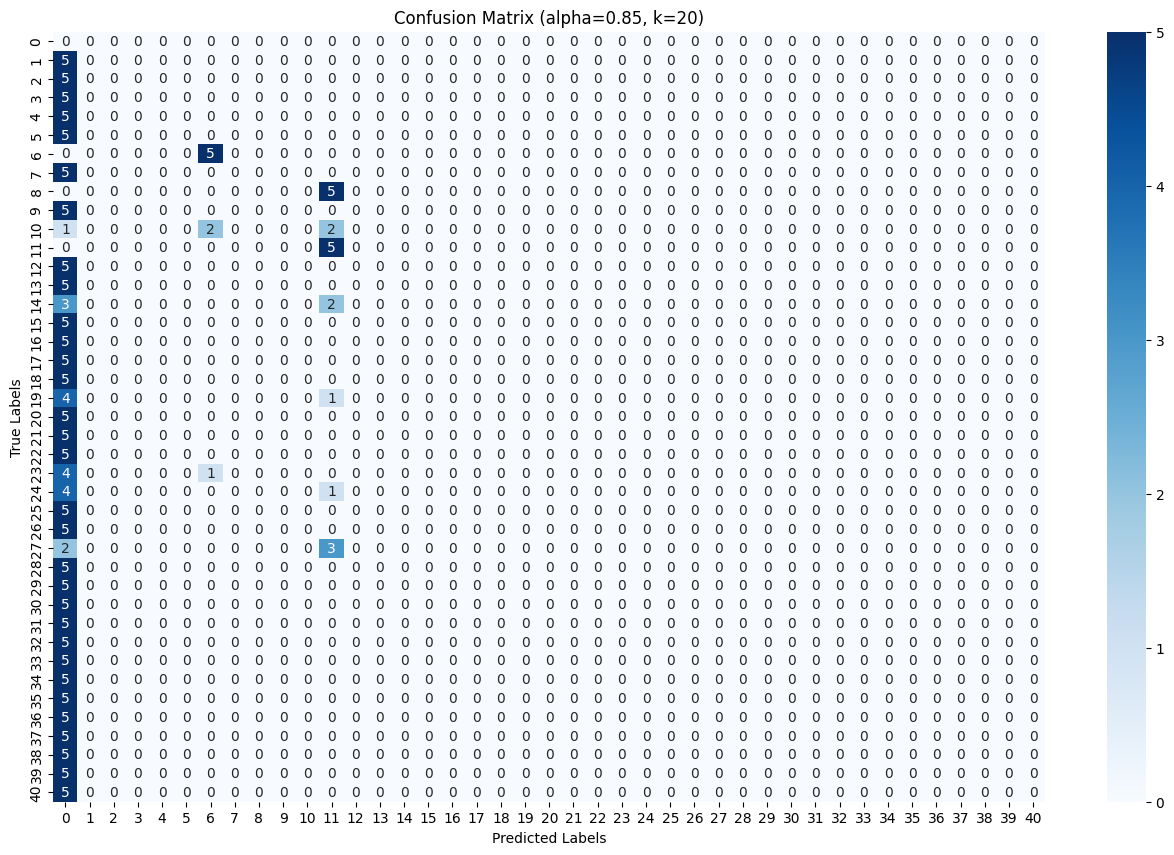

Alpha: 0.85, k: 40:
Accuracy: 0.47
F1-Score: 0.36


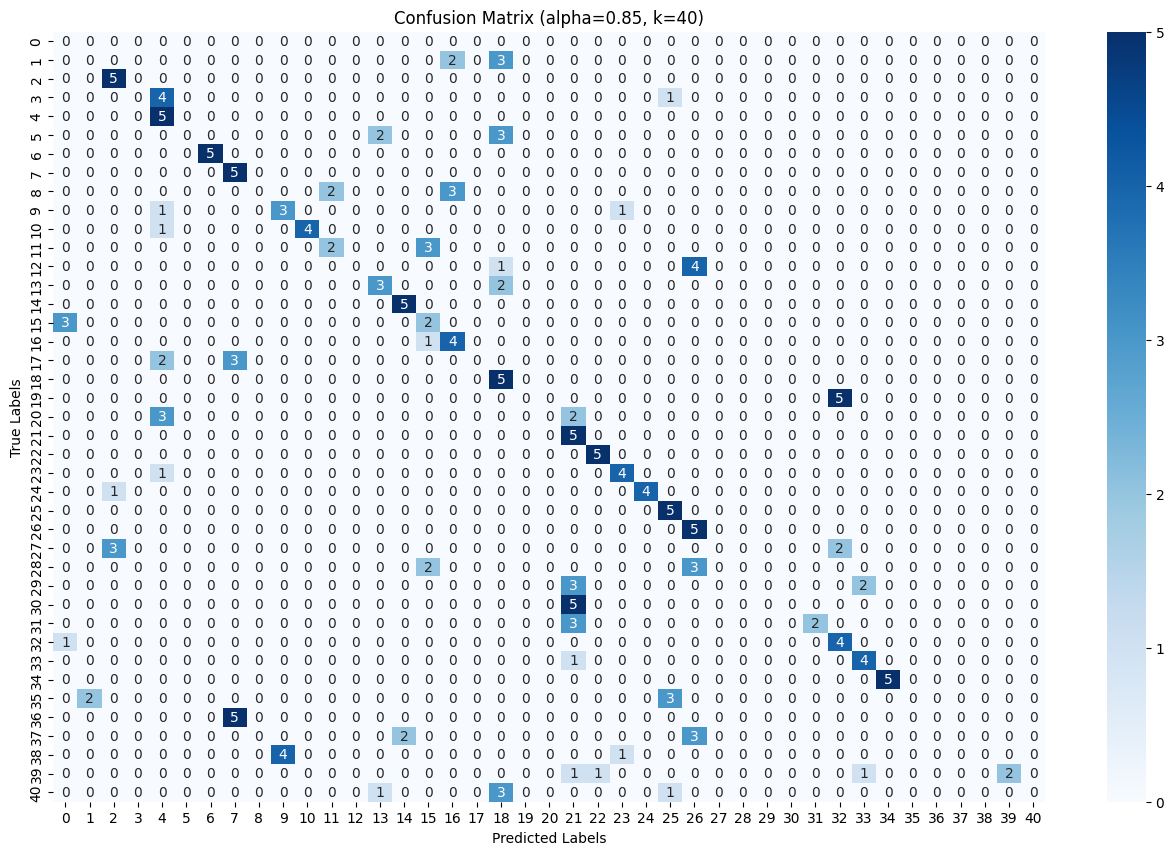

Alpha: 0.85, k: 60:
Accuracy: 0.73
F1-Score: 0.68


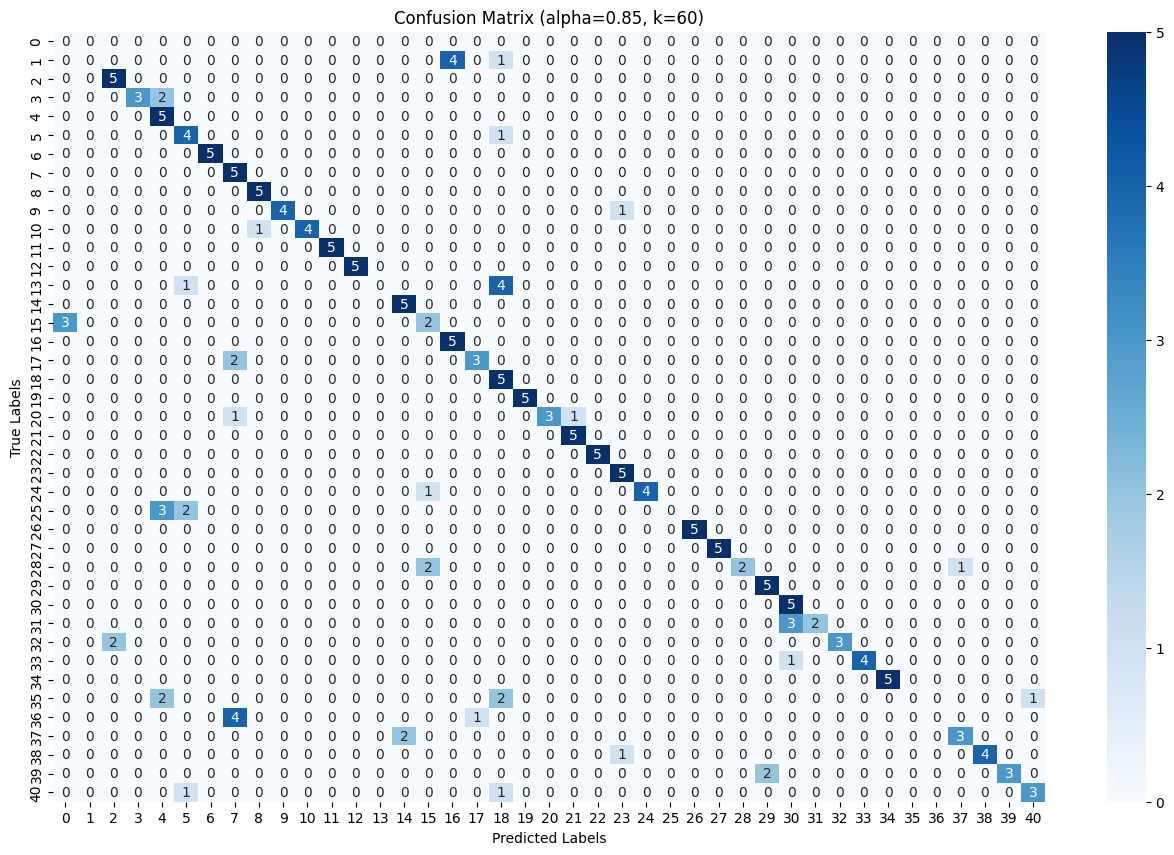

Alpha: 0.9, k: 20:
Accuracy: 0.05
F1-Score: 0.05


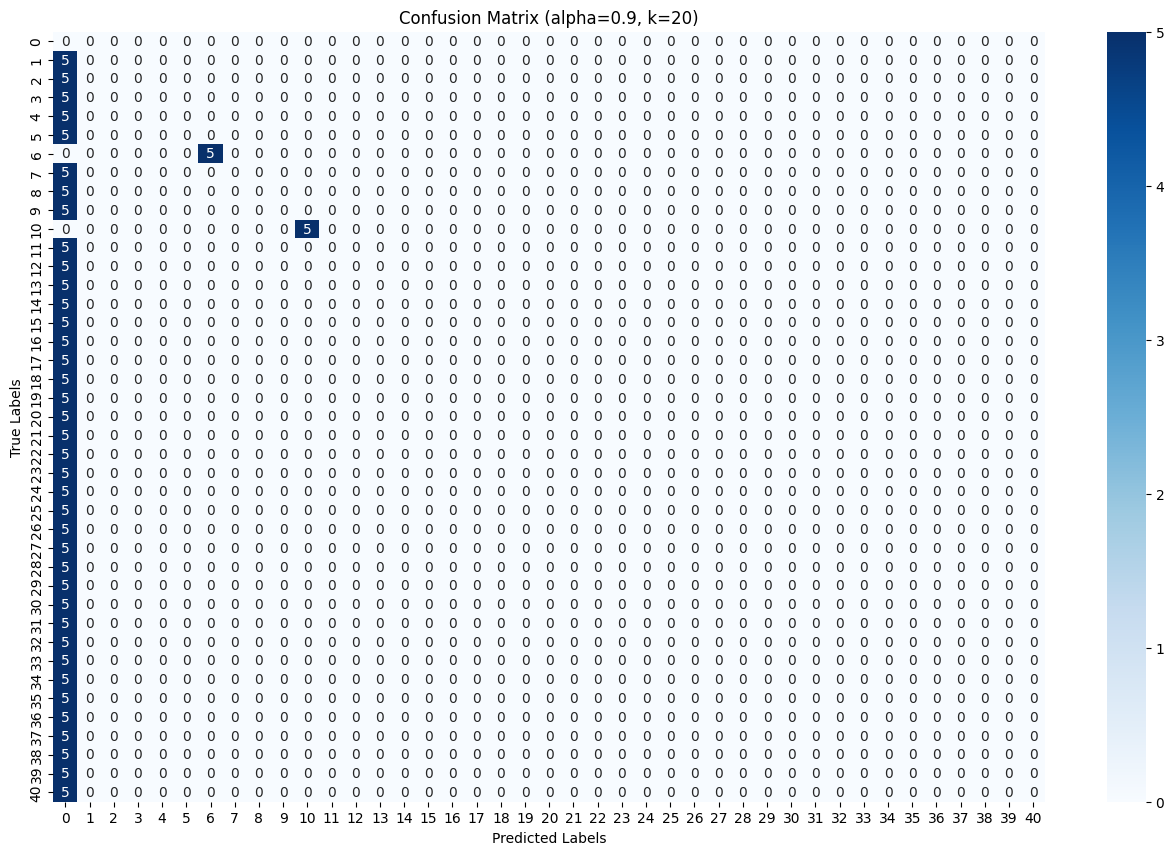

Alpha: 0.9, k: 40:
Accuracy: 0.55
F1-Score: 0.47


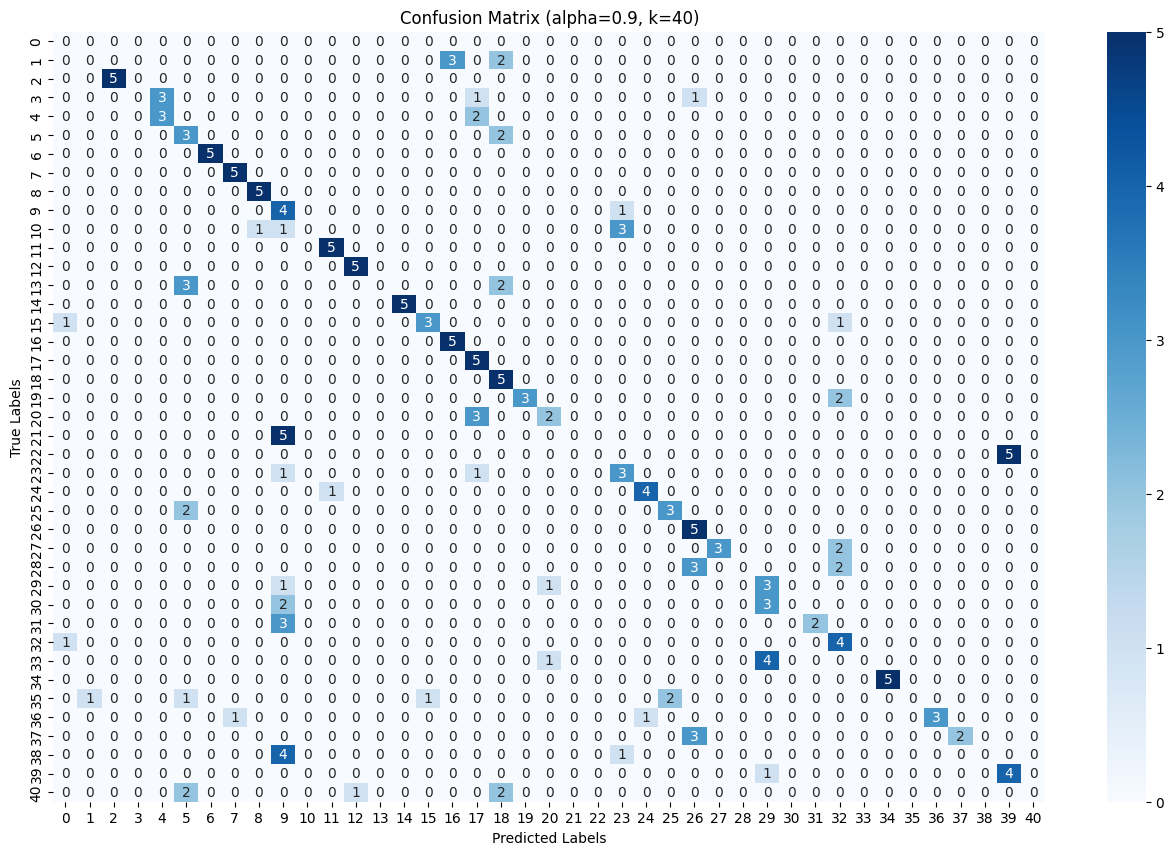

Alpha: 0.9, k: 60:
Accuracy: 0.70
F1-Score: 0.67


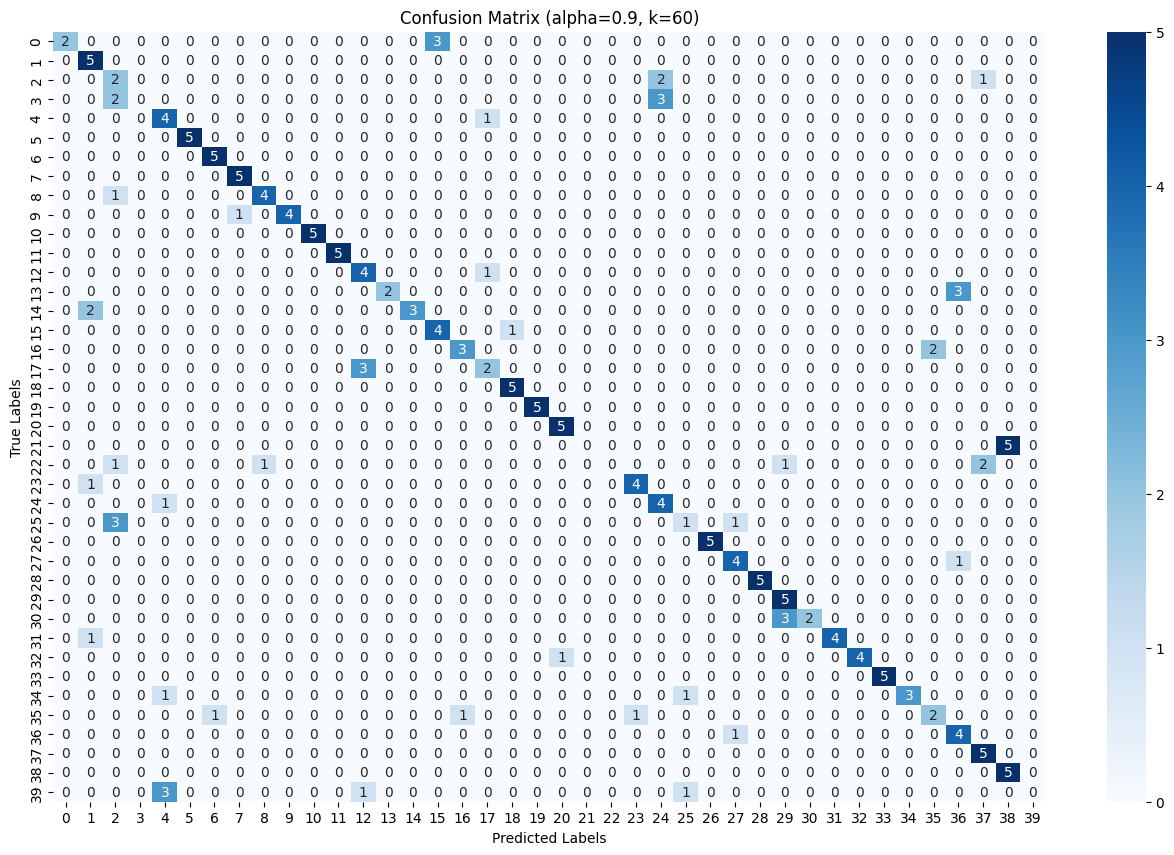

Alpha: 0.95, k: 20:
Accuracy: 0.05
F1-Score: 0.03


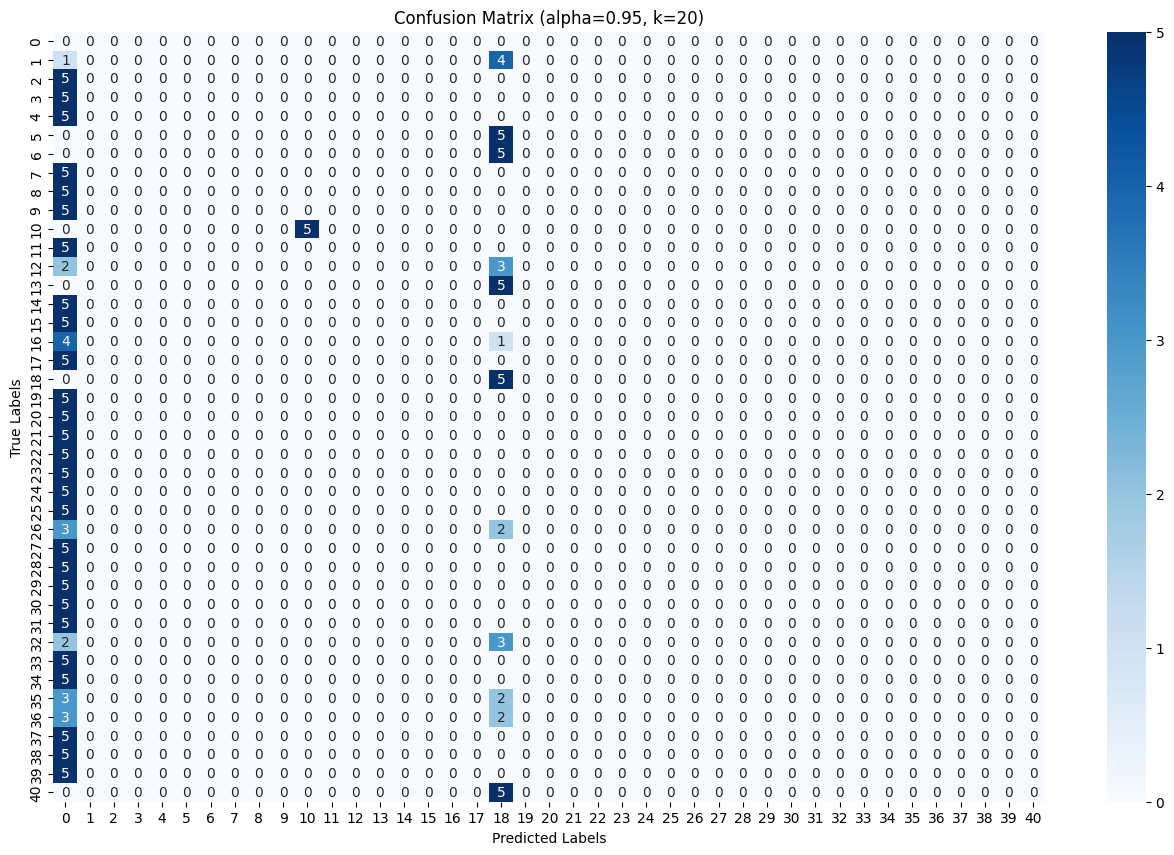

Alpha: 0.95, k: 40:
Accuracy: 0.57
F1-Score: 0.50


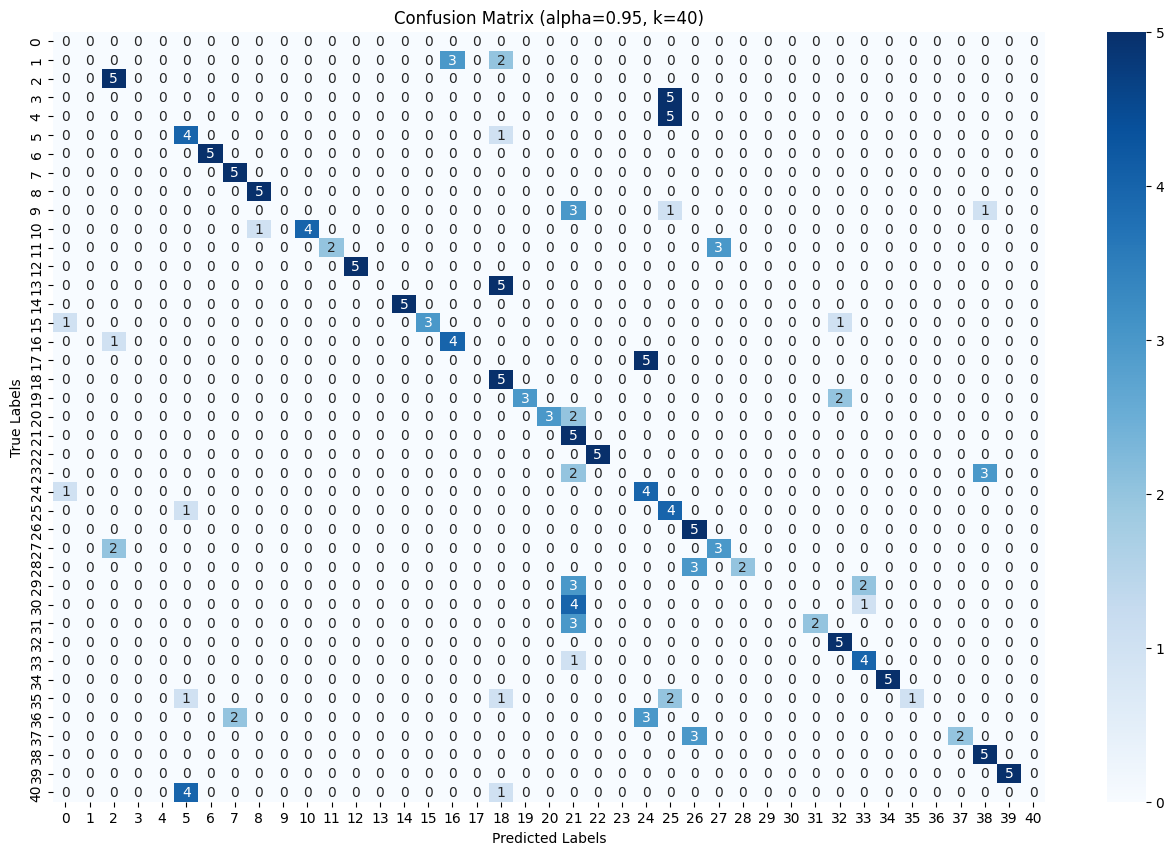

Alpha: 0.95, k: 60:
Accuracy: 0.66
F1-Score: 0.63


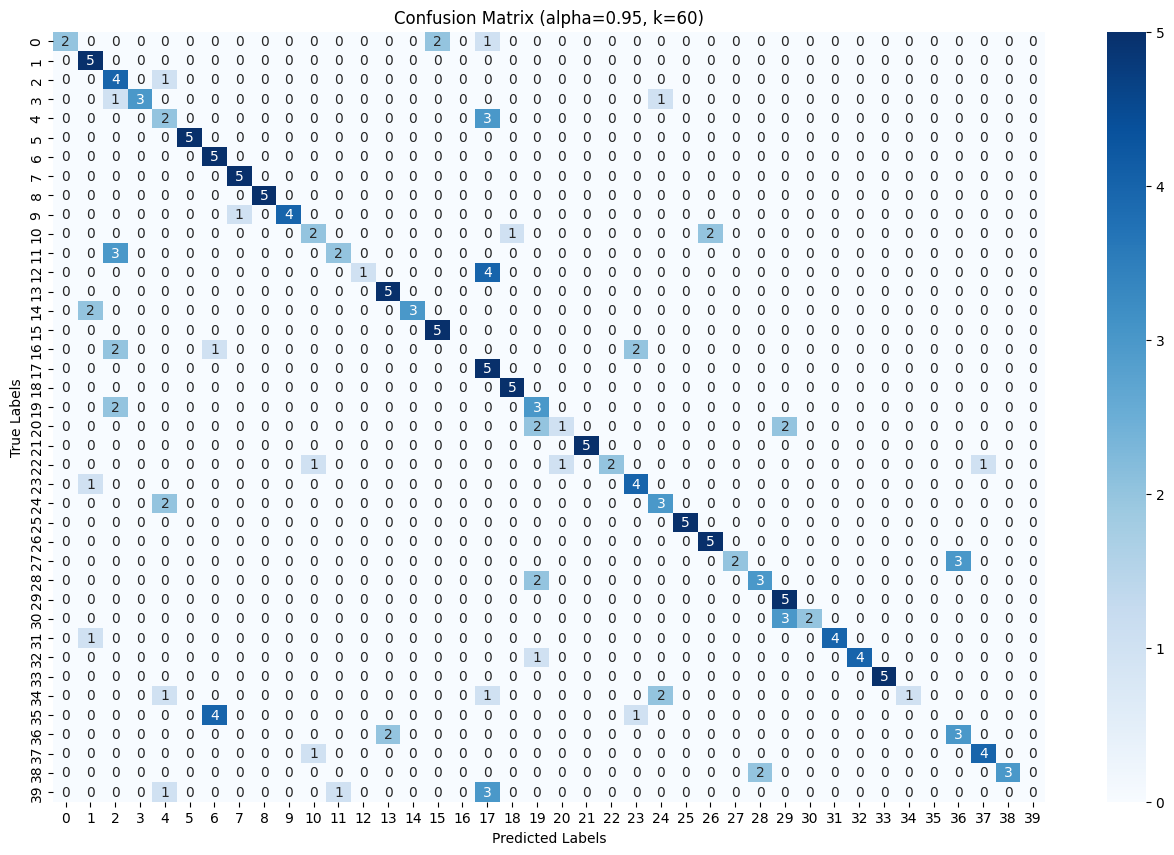

In [23]:
accuracy_results = defaultdict(dict)

for alpha, preds_by_k in predictions.items():
    for k, y_pred in preds_by_k.items():
        acc = accuracy_score(y_test, y_pred)
        accuracy_results[alpha][k] = acc
        
        f1 = f1_score(y_test, y_pred, average='macro')  # 'macro' for multiclass
        
        cm = confusion_matrix(y_test, y_pred)

        print(f"Alpha: {alpha}, k: {k}:")
    
        # Accuracy
        print(f"Accuracy: {acc:.2f}")
        
        # F1-score
        print(f"F1-Score: {f1:.2f}")
        
        # Confusion Matrix
        plt.figure(figsize=(16, 10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion Matrix (alpha={alpha}, k={k})")
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()


In [24]:
# Flatten the dictionary into a list of results
results = []
for alpha, preds_by_k in accuracy_results.items():
    for k, acc in preds_by_k.items():
        results.append({'alpha': alpha, 'k': k, 'accuracy': acc})

# Create a DataFrame
df = pd.DataFrame(results)

# Display the table
print(df)

    alpha   k  accuracy
0    0.80  20     0.025
1    0.80  40     0.565
2    0.80  60     0.685
3    0.85  20     0.050
4    0.85  40     0.465
5    0.85  60     0.730
6    0.90  20     0.050
7    0.90  40     0.545
8    0.90  60     0.705
9    0.95  20     0.050
10   0.95  40     0.575
11   0.95  60     0.660


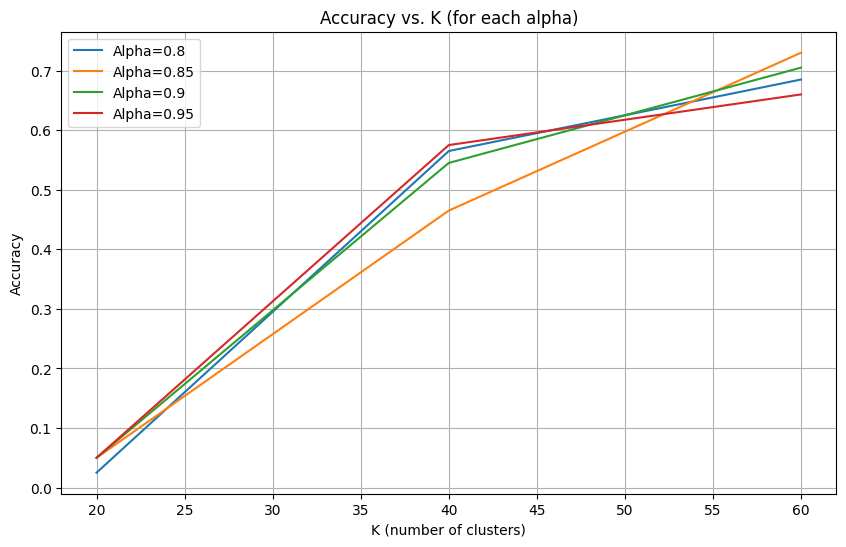

In [25]:
# Plot accuracy for different K values for each alpha
plt.figure(figsize=(10, 6))

for alpha in accuracy_results:
    ks = list(accuracy_results[alpha].keys())
    accuracies = list(accuracy_results[alpha].values())
    plt.plot(ks, accuracies, label=f'Alpha={alpha}')

plt.xlabel('K (number of clusters)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. K (for each alpha)')
plt.legend()
plt.grid(True)
plt.show()

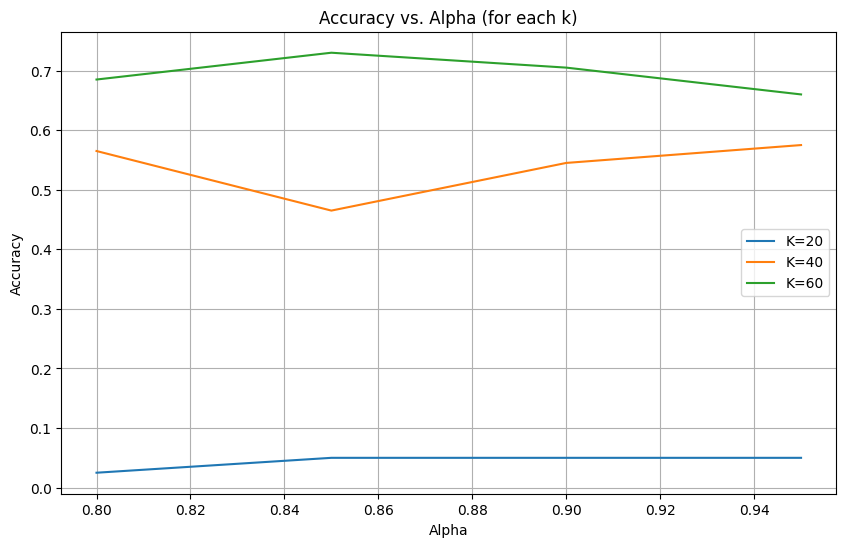

In [26]:
# Plot accuracy for different alpha values for each k
plt.figure(figsize=(10, 6))

for k in accuracy_results[next(iter(accuracy_results))]:  # Assuming k exists for all alphas
    alphas = list(accuracy_results.keys())  # List of alpha values
    accuracies = [accuracy_results[alpha][k] for alpha in alphas]  # Accuracy for each alpha for this k
    plt.plot(alphas, accuracies, label=f'K={k}')

plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Alpha (for each k)')
plt.legend()
plt.grid(True)
plt.show()

# Training using autoencoder

In [27]:
# Convert the data into torch tensors
X_train_tensor = torch.FloatTensor(X_train) / 255.0  # Normalize (important!)
X_test_tensor = torch.FloatTensor(X_test) / 255.0

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



## train
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

autoencoder = Autoencoder(input_dim=10304, latent_dim=100).to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3)
criterion = nn.MSELoss()

n_epochs = 50
autoencoder.train()
for epoch in range(n_epochs):
    running_loss = 0.0
    for batch in train_loader:
        inputs = batch[0].to(device)
        
        optimizer.zero_grad()
        outputs, _ = autoencoder(inputs)
        
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(train_loader):.6f}")

Epoch 1/50, Loss: 0.033515
Epoch 2/50, Loss: 0.025347
Epoch 3/50, Loss: 0.024388
Epoch 4/50, Loss: 0.023824
Epoch 5/50, Loss: 0.023726
Epoch 6/50, Loss: 0.022777
Epoch 7/50, Loss: 0.021296
Epoch 8/50, Loss: 0.020289
Epoch 9/50, Loss: 0.019357
Epoch 10/50, Loss: 0.018758
Epoch 11/50, Loss: 0.018820
Epoch 12/50, Loss: 0.018013
Epoch 13/50, Loss: 0.017312
Epoch 14/50, Loss: 0.016894
Epoch 15/50, Loss: 0.016453
Epoch 16/50, Loss: 0.015799
Epoch 17/50, Loss: 0.015531
Epoch 18/50, Loss: 0.015054
Epoch 19/50, Loss: 0.014630
Epoch 20/50, Loss: 0.014073
Epoch 21/50, Loss: 0.013649
Epoch 22/50, Loss: 0.013244
Epoch 23/50, Loss: 0.012776
Epoch 24/50, Loss: 0.012601
Epoch 25/50, Loss: 0.012330
Epoch 26/50, Loss: 0.011815
Epoch 27/50, Loss: 0.011418
Epoch 28/50, Loss: 0.011330
Epoch 29/50, Loss: 0.011141
Epoch 30/50, Loss: 0.011145
Epoch 31/50, Loss: 0.010949
Epoch 32/50, Loss: 0.010628
Epoch 33/50, Loss: 0.010418
Epoch 34/50, Loss: 0.009828
Epoch 35/50, Loss: 0.009821
Epoch 36/50, Loss: 0.009507
E

In [28]:
autoencoder.eval()
with torch.no_grad():
    _, X_train_latent = autoencoder(X_train_tensor.to(device))
    _, X_test_latent = autoencoder(X_test_tensor.to(device))

# Move to CPU and convert to numpy
X_train_latent = X_train_latent.cpu().numpy()
X_test_latent = X_test_latent.cpu().numpy()

In [29]:
clusters = [20, 40, 60]

# Structure: {k: model}
kmeans_models = {}

for k in clusters:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train_latent, y_train)
    kmeans_models[k] = kmeans

model = kmeans_models[40]
print(f"At k=40 cluster labels:\n{model.labels}")

At k=40 cluster labels:
[19 32 32 19 19 39 39 39 39 39 12 26 26 12 26 30  3 21 30 21 18 18 18 18
 18 25 25 25 25  4 24 24 24 24 24 14 14 14 14 14  3 35  5  3  5  2 27 27
  2  2 33 21 21 33 33 32 18 35 31 18  8 27  8  8 27 31 30  4 31 31 35 35
 25 25  4 18 18 18 18 18 19 27 19 19 19 33 33 21 33 21 37 37 37 37 37 10
 10 10 10 10  8  8  8  8  8  5  5  5  5  5  7  7  7  7 36 37 37 37 14 37
  9  9  9  9  9 16  4 16 35 16 21 21 21 21 21 32  2  2  2  2  6  6  6  6
  6 30 30 30 30 30  3  3  9  3 12  6  9  6  3  6  4 25  4 25  3 16 16 16
 16 37  9  9  9  9  9  9 17 17 36  9 36 36 17 17 36 39 39 39 39 39 34 34
 34 34 34 12 12 26 12 12]


# Testing using autoencoder

In [30]:
predictions = {}

for k, model in kmeans_models.items():
        y_pred = model.predict(X_test_latent)
        predictions[k] = y_pred

# Evaluation using autoencoder

k: 20:
Accuracy: 0.00
F1-Score: 0.00


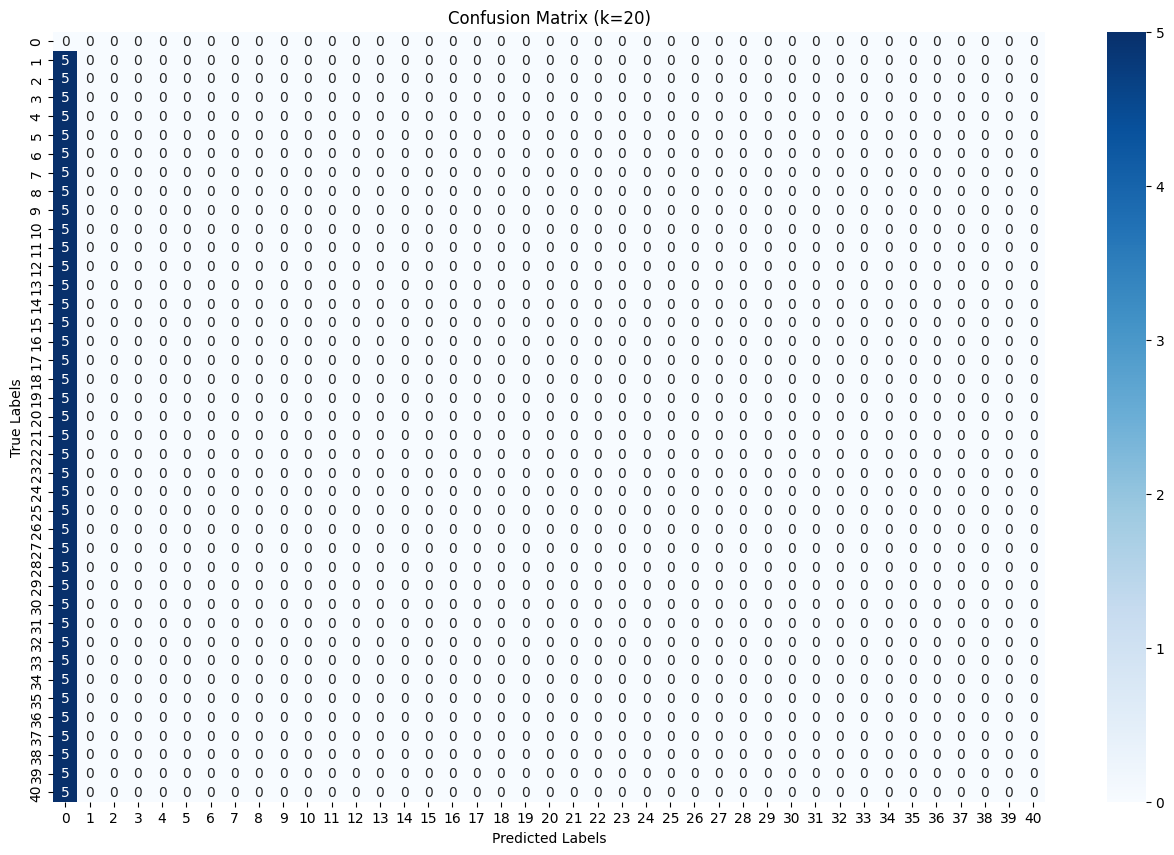

k: 40:
Accuracy: 0.51
F1-Score: 0.44


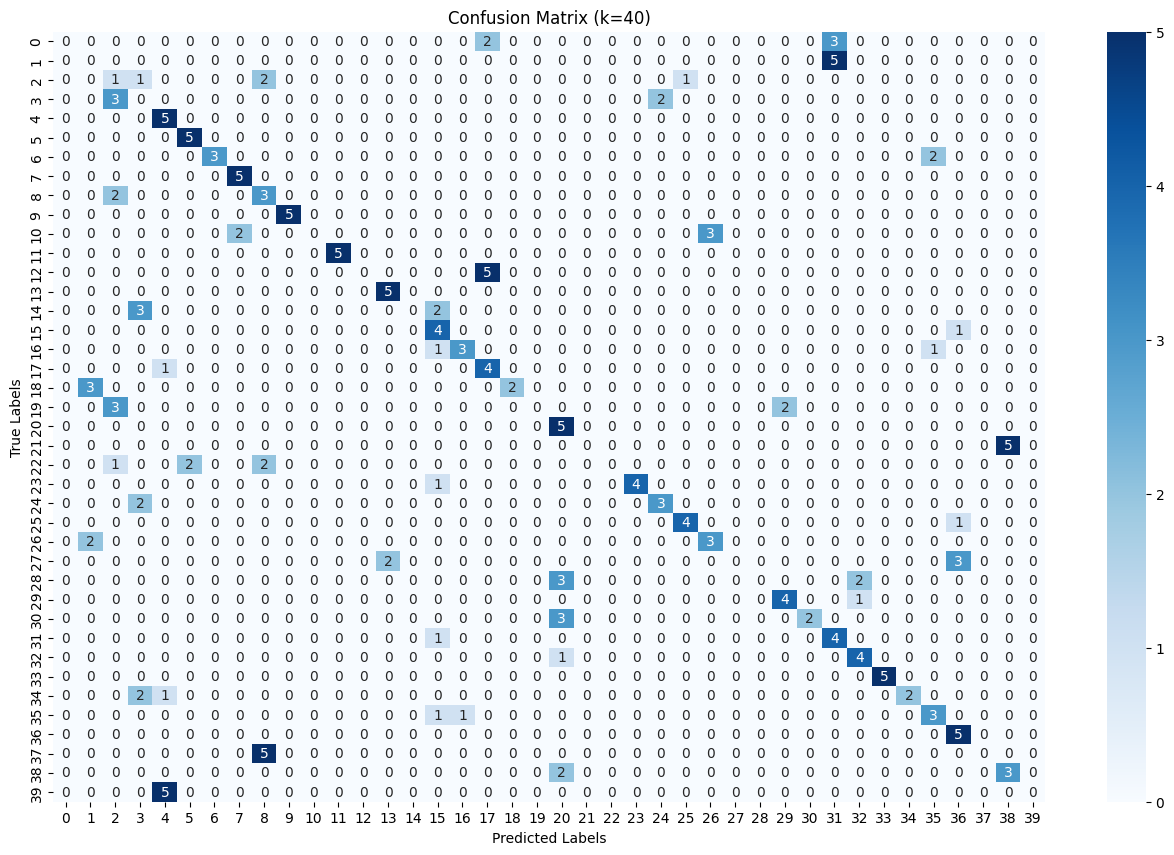

k: 60:
Accuracy: 0.57
F1-Score: 0.53


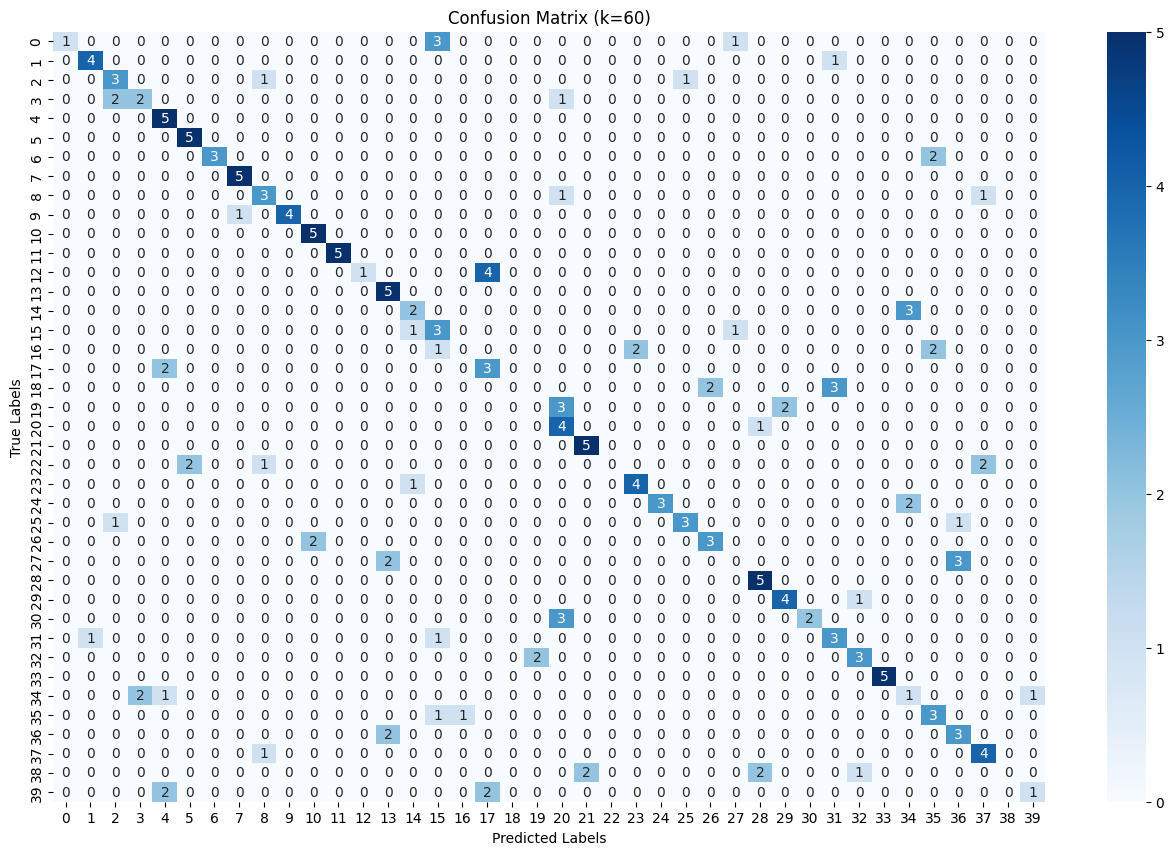

In [31]:
accuracy_results = {}

for k, y_pred in predictions.items():
    acc = accuracy_score(y_test, y_pred)
    accuracy_results[k] = acc
    
    f1 = f1_score(y_test, y_pred, average='macro')  # 'macro' for multiclass
    
    cm = confusion_matrix(y_test, y_pred)

    print(f"k: {k}:")

    # Accuracy
    print(f"Accuracy: {acc:.2f}")
    
    # F1-score
    print(f"F1-Score: {f1:.2f}")
    
    # Confusion Matrix
    plt.figure(figsize=(16, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix (k={k})")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [32]:
# Flatten the dictionary into a list of results
results = []
for k, acc in accuracy_results.items():
    results.append({'k': k, 'accuracy': acc})

# Create a DataFrame
df = pd.DataFrame(results)

# Display the table
print(df)

    k  accuracy
0  20     0.000
1  40     0.505
2  60     0.575


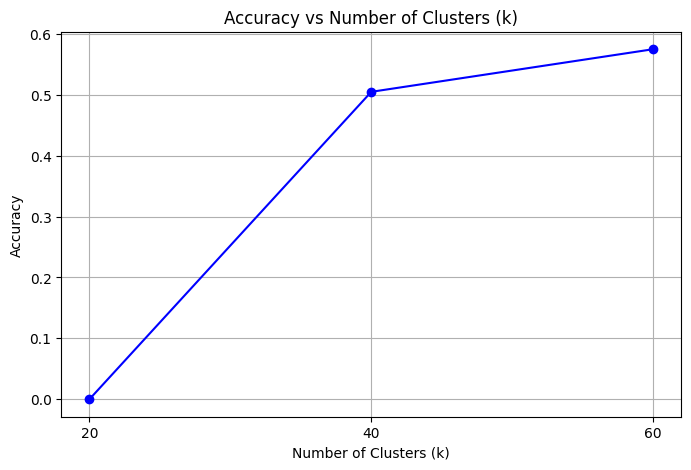

In [33]:
# Plot accuracy for different K values
sorted_k = sorted(accuracy_results.keys())
accuracies = [accuracy_results[k] for k in sorted_k]

plt.figure(figsize=(8, 5))
plt.plot(sorted_k, accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy vs Number of Clusters (k)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(sorted_k)
plt.show()